In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My\ Drive/SOP/SOP_COVID/covid-audio/voice

/content/gdrive/My Drive/SOP/SOP_COVID/covid-audio/voice


In [16]:
import numpy as np
import tensorflow as tf
import os
import keras
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.layers.normalization import BatchNormalization

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

audioType = 'breath'

classes = ['covid', 'normal']

target_size = (224, 224)

# Hyperparameters
epochs = 100
learning_rate = 1e-5
dropout_prob_1 = 0.25
dropout_prob_2 = 0.5

# Early stopping callback
es = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

train_path = f'data_spec/mel_spec_new/spec_{audioType}/train'
valid_path = f'data_spec/mel_spec_new/spec_{audioType}/valid'
test_path = f'data_spec/mel_spec_new/spec_{audioType}/test'

# Imbalanced dataset
# class_weight = {
#     0 : 4.,
#     1 : 1.
# }

In [ ]:
# CNN Based Model in Keras

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(GlobalMaxPooling2D())  # this converts our 3D feature maps to 1D feature vectors
model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
# # CNN Based Model from research paper
# model = Sequential()
# model.add(Conv2D(16,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
# model.add(BatchNormalization())

# model.add(Conv2D(32,(3,3),activation='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(64,(3,3),activation='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(128,(3,3),activation='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(256,(3,3),activation='relu'))
# model.add(BatchNormalization())

# model.add(Conv2D(512,(3,3),activation='relu'))
# model.add(BatchNormalization())

# model.add(GlobalMaxPooling2D())  # this converts our 3D feature maps to 1D feature vectors
# model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 108, 108, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 64)       

In [8]:
# Train from scratch
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    # horizontal_flip = True,
)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = target_size,
    color_mode="rgb", # for coloured images
    batch_size = 32,
    class_mode = 'binary'
)

print(train_generator.class_indices)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size = target_size,
    color_mode="rgb", # for coloured images
    batch_size = 32,
    class_mode = 'binary'
)

# Choosing steps per epoch so that 1 epoch equals 1 pass through train/valid/test (steps = samples / batch_size).
train_batch_size = 32
train_steps = round(train_generator.n / train_batch_size)
valid_batch_size = 32
valid_steps = round(validation_generator.n / valid_batch_size)

Found 287 images belonging to 2 classes.
{'covid': 0, 'normal': 1}
Found 37 images belonging to 2 classes.


In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=valid_steps,
    callbacks=[es]
)

model_name = f'model_CNN_{audioType}_epochs_lr_new'
model.save('models/' + model_name + '.h5')

with open(f'history/{model_name}_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
9/9 [==============================] - 5s 573ms/step - loss: 0.7021 - accuracy: 0.4739 - val_loss: 0.6922 - val_accuracy: 0.6250
Epoch 2/100
9/9 [==============================] - 5s 521ms/step - loss: 0.6991 - accuracy: 0.5087 - val_loss: 0.6903 - val_accuracy: 0.5000
Epoch 3/100
9/9 [==============================] - 5s 519ms/step - loss: 0.6864 - accuracy: 0.5505 - val_loss: 0.6928 - val_accuracy: 0.4375
Epoch 4/100
9/9 [==============================] - 5s 517ms/step - loss: 0.6920 - accuracy: 0.5296 - val_loss: 0.6903 - val_accuracy: 0.5625
Epoch 5/100
9/9 [==============================] - 5s 526ms/step - loss: 0.6801 - accuracy: 0.6063 - val_loss: 0.6878 - val_accuracy: 0.6875
Epoch 6/100
9/9 [==============================] - 5s 531ms/step - loss: 0.6943 - accuracy: 0.5226 - val_loss: 0.6881 - val_accuracy: 0.7500
Epoch 7/100
9/9 [==============================] - 5s 527ms/step - loss: 0.6746 - accuracy: 0.5749 - val_loss: 0.6877 - val_accuracy: 0.7500
Epoch 8/100
9

## Test Images

In [10]:
model_name = f'model_CNN_{audioType}_epochs_lr_new'
model = load_model('models/' + model_name + '.h5')

In [11]:
y_actual = []
y_test = []

In [12]:
for class_ in classes:
    class_path = os.path.join(test_path, class_)
    for i in os.listdir(class_path):
        img = image.load_img(os.path.join(class_path, i), target_size=(224,224))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis = 0)
        p = model.predict_classes(img)
        y_test.append(p[0])
        y_actual.append(train_generator.class_indices[class_])

In [13]:
y_actual = np.array(y_actual)
y_test = np.array(y_test)

[[15  3]
 [62 18]]
Accuracy:  0.336734693877551
              precision    recall  f1-score   support

           0       0.19      0.83      0.32        18
           1       0.86      0.23      0.36        80

    accuracy                           0.34        98
   macro avg       0.53      0.53      0.34        98
weighted avg       0.74      0.34      0.35        98



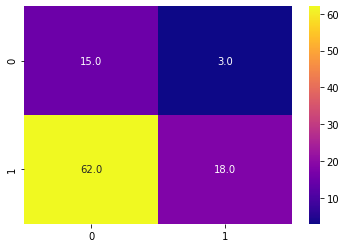

In [17]:
cm = confusion_matrix(y_actual, y_test)
print(cm)
sns.heatmap(cm, cmap = 'plasma', annot = True, fmt = ".1f")
print('Accuracy: ', accuracy_score(y_actual, y_test))
print(classification_report(y_actual, y_test))